# Specialist Weather Prediction Pipeline

## Overview
This notebook implements and compares different base learners for 3 prediction tasks: Cold, Fog, and Storm severe weather events. We use a **Binary Relevance** approach (one specialist model per event type) with **Expanding Window Temporal Cross-Validation**.

## Strategy: Specialist Models
Instead of one model for all events, we train independent "specialist" models:

| Model | Target | Why Separate? |
|-------|--------|---------------|
| Model A | Cold | Driven by temperature drops, pressure systems |
| Model B | Fog | Driven by humidity, temperature-dew point spread |
| Model C | Storm | Driven by pressure instability, wind patterns |

## Validation: Expanding Window Temporal CV (4 Folds)

Tests: **"Does the model generalize to future time periods?"**

| Fold | Training Period | Validation Period |
|------|-----------------|-------------------|
| 1 | Jan 2019 – Dec 2019 | Jan – Mar 2020 |
| 2 | Jan 2019 – Mar 2020 | Apr – Jun 2020 |
| 3 | Jan 2019 – Jun 2020 | Jul – Sep 2020 |
| 4 | Jan 2019 – Sep 2020 | Oct – Dec 2020 |

This prevents **temporal leakage** and simulates real deployment (train on past, predict future).

## Models & Imbalance Handling

| Model | Imbalance Mechanism |
|-------|---------------------|
| Logistic Regression | `class_weight='balanced'` |
| Random Forest | `class_weight='balanced_subsample'` |
| XGBoost | `scale_pos_weight` (Neg/Pos ratio) |
| CatBoost | `auto_class_weights='Balanced'` |

## KPIs
- **ROC-AUC**: Ranking ability (1.0 = perfect, 0.5 = random)
- **Brier Score (MSE)**: Probability calibration (0.0 = perfect)

## Section 1: Setup and Imports

We need the following packages:
- **pandas/numpy**: Data manipulation
- **scikit-learn**: Logistic Regression, Random Forest, preprocessing, metrics
- **xgboost**: Gradient boosting classifier
- **catboost**: Ordered gradient boosting with best probability calibration
- **matplotlib/seaborn**: Visualization
- **tqdm**: Progress bars for long training loops

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm import tqdm

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All packages imported successfully!")

All packages imported successfully!


## Section 2: Load Data

We load the pre-processed dataset that contains:
- **Daily weather observations** for multiple cities/states
- **Weather features**: temperature, humidity, pressure, wind, precipitation, cloud cover
- **Event labels**: Which severe weather events occurred on each day

The data covers 2019-2020, which gives us enough temporal range for expanding window validation.

In [2]:
# Load the dataset
DATA_PATH = "Processed Data/weather_with_severe_events_2019_2020.csv"
df = pd.read_csv(DATA_PATH)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display basic info
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Unique States: {df['State'].nunique()}")
print(f"Unique Cities: {df['City'].nunique()}")
print(f"\nStates in dataset: {sorted(df['State'].unique())}")

# Preview the data
df.head()

Dataset Shape: 253,657 rows × 29 columns
Date Range: 2019-01-01 to 2020-12-31
Unique States: 47
Unique Cities: 347

States in dataset: ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


,Date,City,State,Latitude,Longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,...,pressure_msl_max,pressure_msl_min,pressure_msl_mean,cloud_cover_mean,HasExtremeEvent,EventCount,Events,Event_Types,Event_Severities,Event_Ids
0,2019-01-01,Columbus,MS,33.6438,-88.4438,15.5,10.2,12.7,0.7,0.7,...,1022.8,1015.2,1019.6,97,False,0,NaN,NaN,NaN,NaN
1,2019-01-02,Columbus,MS,33.6438,-88.4438,10.7,7.7,8.9,10.5,10.5,...,1024.7,1019.8,1022.8,98,False,0,NaN,NaN,NaN,NaN
2,2019-01-03,Columbus,MS,33.6438,-88.4438,12.7,7.6,9.2,27.7,27.7,...,1020.7,1014.7,1018.2,100,True,3,"[{""EventId"": ""W-860932"", ""Type"": ""Cold"", ""Seve...",Cold,Severe,"W-860932, W-860933, W-860934"
3,2019-01-04,Columbus,MS,33.6438,-88.4438,13.4,7.4,9.9,19.2,19.2,...,1015.0,1004.5,1009.2,96,True,3,"[{""EventId"": ""W-860936"", ""Type"": ""Cold"", ""Seve...",Cold,Severe,"W-860936, W-860938, W-860943"
4,2019-01-05,Columbus,MS,33.6438,-88.4438,15.0,3.3,8.0,0.0,0.0,...,1021.1,1011.3,1017.7,25,False,0,NaN,NaN,NaN,NaN


## Section 3: Create Binary Target Variables

The `Event_Types` column contains comma-separated event types (e.g., "Cold", "Cold, Fog"). 
We need to parse this into **separate binary columns** for each specialist model:

- `has_cold`: 1 if Cold event occurred, 0 otherwise
- `has_fog`: 1 if Fog event occurred, 0 otherwise
- `has_storm`: 1 if Storm event occurred, 0 otherwise

### Why Binary Relevance?
This approach treats each label independently. While it ignores potential correlations between events (e.g., storms often bring cold), it:
1. Allows specialized tuning per event type
2. Handles different imbalance ratios independently
3. Is simpler to interpret and debug

In [3]:
# Create binary target columns by checking if event type is in the Event_Types string
def create_binary_target(event_types_col, target_event):
    """
    Parse Event_Types column and create binary indicator for a specific event.
    
    Args:
        event_types_col: Series containing event type strings (e.g., "Cold", "Cold, Fog")
        target_event: The event to look for (e.g., "Cold")
    
    Returns:
        Binary series (1 if event present, 0 otherwise)
    """
    return event_types_col.fillna('').str.contains(target_event, case=False).astype(int)

# Create binary targets for each event type
df['has_cold'] = create_binary_target(df['Event_Types'], 'Cold')
df['has_fog'] = create_binary_target(df['Event_Types'], 'Fog')
df['has_storm'] = create_binary_target(df['Event_Types'], 'Storm')

# Display class distribution for each target
print("=" * 60)
print("CLASS DISTRIBUTION (Imbalance Analysis)")
print("=" * 60)

targets = ['has_cold', 'has_fog', 'has_storm']
for target in targets:
    pos_count = df[target].sum()
    neg_count = len(df) - pos_count
    pos_pct = 100 * pos_count / len(df)
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else float('inf')
    
    print(f"\n{target.upper().replace('HAS_', '')}:")
    print(f"  Positive (Event):     {pos_count:>6,} ({pos_pct:>5.2f}%)")
    print(f"  Negative (No Event):  {neg_count:>6,} ({100-pos_pct:>5.2f}%)")
    print(f"  Imbalance Ratio:      1:{imbalance_ratio:.1f}")

CLASS DISTRIBUTION (Imbalance Analysis)

COLD:
  Positive (Event):      8,144 ( 3.21%)
  Negative (No Event):  245,513 (96.79%)
  Imbalance Ratio:      1:30.1

FOG:
  Positive (Event):     37,868 (14.93%)
  Negative (No Event):  215,789 (85.07%)
  Imbalance Ratio:      1:5.7

STORM:
  Positive (Event):      1,904 ( 0.75%)
  Negative (No Event):  251,753 (99.25%)
  Imbalance Ratio:      1:132.2


## Section 4: Feature Engineering (Advanced)

We engineer features at multiple levels to capture different aspects of weather patterns:

### 4.1 Base Features
Raw weather measurements from the dataset (temperature, humidity, pressure, wind, etc.)

### 4.2 Temporal Features
- **Month, Day of Year**: Capture seasonality (for example - storms more common in spring/summer)
- **Season**: Categorical encoding of meteorological seasons

### 4.3 Derived Features
- **Temperature Range**: Large daily swings may indicate instability
- **Pressure Range**: Rapid pressure changes often precede storms
- **Humidity Range**: Variability in moisture content

### 4.4 Lag Features
Previous day's values help capture **trends**. If pressure dropped yesterday, it might continue dropping.

### 4.5 Rolling Statistics
7-day rolling mean and standard deviation capture **recent weather patterns** and variability.

**Important**: Lag and rolling features must be computed **per location** (City) to avoid data leakage across different places.

In [4]:
# Define base feature columns (raw weather measurements)
BASE_FEATURES = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean',
    'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'cloud_cover_mean', 'shortwave_radiation_sum'
]

# Verify all base features exist in the dataset
missing_features = [f for f in BASE_FEATURES if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    BASE_FEATURES = [f for f in BASE_FEATURES if f in df.columns]

print(f"Using {len(BASE_FEATURES)} base features")
print(BASE_FEATURES)

Using 18 base features
['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean', 'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'cloud_cover_mean', 'shortwave_radiation_sum']


In [5]:
# ============================================================
# 4.2 TEMPORAL FEATURES
# ============================================================
# These capture seasonality - weather events have strong seasonal patterns

# Month (1-12): Captures monthly patterns
df['month'] = df['Date'].dt.month

# Day of year (1-365): Captures finer seasonal patterns
df['day_of_year'] = df['Date'].dt.dayofyear

# Season: Meteorological seasons
# Winter: Dec, Jan, Feb (12, 1, 2)
# Spring: Mar, Apr, May (3, 4, 5)
# Summer: Jun, Jul, Aug (6, 7, 8)
# Fall: Sep, Oct, Nov (9, 10, 11)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(get_season)

TEMPORAL_FEATURES = ['month', 'day_of_year', 'season']
print(f"Created {len(TEMPORAL_FEATURES)} temporal features: {TEMPORAL_FEATURES}")

Created 3 temporal features: ['month', 'day_of_year', 'season']


In [6]:
# ============================================================
# 4.3 DERIVED FEATURES
# ============================================================
# These capture daily variability which can indicate weather instability

# Temperature range: Large swings may indicate frontal passages
df['temp_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

# Pressure range: Rapid changes often precede severe weather
df['pressure_range'] = df['pressure_msl_max'] - df['pressure_msl_min']

# Humidity range: Variability in moisture
df['humidity_range'] = df['relative_humidity_2m_max'] - df['relative_humidity_2m_min']

DERIVED_FEATURES = ['temp_range', 'pressure_range', 'humidity_range']
print(f"Created {len(DERIVED_FEATURES)} derived features: {DERIVED_FEATURES}")

Created 3 derived features: ['temp_range', 'pressure_range', 'humidity_range']


In [7]:
# ============================================================
# 4.4 & 4.5 LAG AND ROLLING FEATURES
# ============================================================
# CRITICAL: Must be computed per City to avoid spatial data leakage!
# We sort by Date within each City before computing lags/rolling.

# Features to create lags and rolling stats for
KEY_FEATURES = ['temperature_2m_mean', 'pressure_msl_mean', 'relative_humidity_2m_mean']

# Sort data by City and Date (required for proper lag/rolling computation)
df = df.sort_values(['City', 'Date']).reset_index(drop=True)

LAG_FEATURES = []
ROLLING_FEATURES = []

print("Computing lag and rolling features per city...")

for feature in tqdm(KEY_FEATURES, desc="Processing features"):
    # --- LAG FEATURES ---
    # Lag 1: Previous day's value
    lag1_name = f'{feature}_lag1'
    df[lag1_name] = df.groupby('City')[feature].shift(1)
    LAG_FEATURES.append(lag1_name)
    
    # Lag 3: Value from 3 days ago (captures short-term trends)
    lag3_name = f'{feature}_lag3'
    df[lag3_name] = df.groupby('City')[feature].shift(3)
    LAG_FEATURES.append(lag3_name)
    
    # --- ROLLING FEATURES ---
    # 7-day rolling mean: Recent average conditions
    roll_mean_name = f'{feature}_rolling7_mean'
    df[roll_mean_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    ROLLING_FEATURES.append(roll_mean_name)
    
    # 7-day rolling std: Recent variability
    roll_std_name = f'{feature}_rolling7_std'
    df[roll_std_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    ROLLING_FEATURES.append(roll_std_name)

print(f"\nCreated {len(LAG_FEATURES)} lag features: {LAG_FEATURES}")
print(f"Created {len(ROLLING_FEATURES)} rolling features: {ROLLING_FEATURES}")

Computing lag and rolling features per city...


Processing features: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


Created 6 lag features: ['temperature_2m_mean_lag1', 'temperature_2m_mean_lag3', 'pressure_msl_mean_lag1', 'pressure_msl_mean_lag3', 'relative_humidity_2m_mean_lag1', 'relative_humidity_2m_mean_lag3']
Created 6 rolling features: ['temperature_2m_mean_rolling7_mean', 'temperature_2m_mean_rolling7_std', 'pressure_msl_mean_rolling7_mean', 'pressure_msl_mean_rolling7_std', 'relative_humidity_2m_mean_rolling7_mean', 'relative_humidity_2m_mean_rolling7_std']


In [8]:
# ============================================================
# COMBINE ALL FEATURES AND HANDLE MISSING VALUES
# ============================================================

# Combine all feature lists
ALL_FEATURES = BASE_FEATURES + TEMPORAL_FEATURES + DERIVED_FEATURES + LAG_FEATURES + ROLLING_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  - Base features: {len(BASE_FEATURES)}")
print(f"  - Temporal features: {len(TEMPORAL_FEATURES)}")
print(f"  - Derived features: {len(DERIVED_FEATURES)}")
print(f"  - Lag features: {len(LAG_FEATURES)}")
print(f"  - Rolling features: {len(ROLLING_FEATURES)}")

# Check for missing values
rows_before = len(df)
missing_rows = df[ALL_FEATURES].isnull().any(axis=1).sum()
print(f"\nRows with missing values: {missing_rows:,} ({100*missing_rows/rows_before:.2f}%)")

# Why we DROP instead of impute:
# - Missing values only occur in first ~3 days per city (lag/rolling features)
# - These rows lack meaningful historical context anyway
# - Dropping is cleaner than imputing artificial values
# - Data loss is minimal (~3 days × n_cities)

df = df.dropna(subset=ALL_FEATURES).reset_index(drop=True)

rows_after = len(df)
print(f"Rows dropped: {rows_before - rows_after:,}")
print(f"Rows remaining: {rows_after:,} ({100*rows_after/rows_before:.2f}%)")

Total features: 36
  - Base features: 18
  - Temporal features: 3
  - Derived features: 3
  - Lag features: 6
  - Rolling features: 6

Rows with missing values: 1,041 (0.41%)
Rows dropped: 1,041
Rows remaining: 252,616 (99.59%)


## Section 5: Cross-Validation Framework

We implement **Expanding Window Temporal Cross-Validation** to test time-series generalization:

### Expanding Window (4 folds)
- **Goal**: Test if model generalizes to **future time periods**
- **Method**: Train on historical data, validate on future quarters with expanding training window
- **Why**: Weather prediction must work on future dates, not just historical ones

This prevents **temporal leakage** and answers: **"Will this model work on next quarter's data?"**

In [9]:
# ============================================================
# EXPANDING WINDOW TEMPORAL SPLITTER
# ============================================================
# Implements time-series cross-validation with expanding training window.
# Training window grows over time, validation is always the next quarter.

class ExpandingWindowSplit:
    """
    Temporal cross-validator using expanding training windows.
    
    This mimics real-world deployment: train on all historical data,
    predict future periods. The training set grows with each fold.
    """
    
    def __init__(self):
        # Define the temporal folds
        # Format: (train_end_date, val_start_date, val_end_date)
        self.folds = [
            ('2019-12-31', '2020-01-01', '2020-03-31'),  # Fold 1: Full 2019 → Q1 2020
            ('2020-03-31', '2020-04-01', '2020-06-30'),  # Fold 2: +Q1 2020 → Q2 2020
            ('2020-06-30', '2020-07-01', '2020-09-30'),  # Fold 3: +Q2 2020 → Q3 2020
            ('2020-09-30', '2020-10-01', '2020-12-31'),  # Fold 4: +Q3 2020 → Q4 2020
        ]
        # Training always starts from the beginning of the dataset
        self.train_start = '2019-01-01'
    
    def split(self, df, date_col='Date'):
        """
        Generate indices for expanding window splits.
        
        Args:
            df: DataFrame with data
            date_col: Name of the date column
        
        Yields:
            train_idx, val_idx: Arrays of indices
        """
        dates = pd.to_datetime(df[date_col])
        
        for train_end, val_start, val_end in self.folds:
            train_end = pd.to_datetime(train_end)
            val_start = pd.to_datetime(val_start)
            val_end = pd.to_datetime(val_end)
            
            # Training: all data from start up to train_end
            train_mask = (dates >= self.train_start) & (dates <= train_end)
            
            # Validation: data in the validation window
            val_mask = (dates >= val_start) & (dates <= val_end)
            
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only yield if both sets have data
            if len(train_idx) > 0 and len(val_idx) > 0:
                yield train_idx, val_idx
    
    def get_n_splits(self):
        return len(self.folds)

# Create the temporal CV splitter
temporal_cv = ExpandingWindowSplit()

print("Expanding Window Temporal CV Configuration:")
print(f"  Number of folds: {temporal_cv.get_n_splits()}")
print(f"\nFold details:")
for i, (train_end, val_start, val_end) in enumerate(temporal_cv.folds, 1):
    print(f"  Fold {i}: Train until {train_end} → Validate {val_start} to {val_end}")

Expanding Window Temporal CV Configuration:
  Number of folds: 4

Fold details:
  Fold 1: Train until 2019-12-31 → Validate 2020-01-01 to 2020-03-31
  Fold 2: Train until 2020-03-31 → Validate 2020-04-01 to 2020-06-30
  Fold 3: Train until 2020-06-30 → Validate 2020-07-01 to 2020-09-30
  Fold 4: Train until 2020-09-30 → Validate 2020-10-01 to 2020-12-31


In [10]:
# Cell removed - ExpandingWindowSplit is now in the cell above

## Section 6: Model Definitions

We compare **4 model architectures**, each with built-in handling for class imbalance:

| Model | Type | Imbalance Handling |
|-------|------|-------------------|
| **Logistic Regression** | Linear | `class_weight='balanced'` - Upweights minority class |
| **Random Forest** | Bagging (Trees) | `class_weight='balanced_subsample'` - Rebalances per bootstrap |
| **XGBoost** | Boosting (Trees) | `scale_pos_weight` - Upweights positive class gradient |
| **CatBoost** | Boosting (Trees) | `auto_class_weights='Balanced'` - Automatic balancing |

### Why These Models?
- **Logistic Regression**: Simple, interpretable baseline. Tests if linear patterns are sufficient.
- **Random Forest**: Bagging approach - averages many independent trees. Robust to outliers.
- **XGBoost**: Gradient boosting - sequential trees that correct errors. Fast and popular.
- **CatBoost**: Ordered boosting - prevents target leakage. **Best probability calibration**.

In [11]:
# ============================================================
# MODEL FACTORY
# ============================================================
# Creates fresh model instances with appropriate imbalance handling.

def create_models(n_positive, n_negative):
    """
    Create dictionary of models with imbalance-aware configurations.
    
    Args:
        n_positive: Number of positive samples in training set
        n_negative: Number of negative samples in training set
    
    Returns:
        Dictionary of model name → model instance
    """
    # Calculate imbalance ratio for XGBoost
    scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0
    
    models = {
        'Logistic_Regression': LogisticRegression(
            class_weight='balanced',  # Auto-balances based on class frequency
            max_iter=1000,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        
        'Random_Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced_subsample',  # Balance per bootstrap sample
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1  # Use all CPU cores
        ),
        
        'XGBoost': XGBClassifier(
            n_estimators=100,
            scale_pos_weight=scale_pos_weight,  # Upweight positive class
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0
        ),
        
        'CatBoost': CatBoostClassifier(
            iterations=100,
            auto_class_weights='Balanced',  # Automatic class balancing
            depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            verbose=0  # Silent mode
        )
    }
    
    return models

print("Model factory defined!")
print("Models: Logistic Regression, Random Forest, XGBoost, CatBoost")

Model factory defined!
Models: Logistic Regression, Random Forest, XGBoost, CatBoost


## Section 7: Main Training Loop

We use **Expanding Window Temporal Cross-Validation** (4 folds):

- Train on historical data, validate on future quarters
- Each fold: Training window expands, validation window slides forward
- This tests: **"Does the model generalize to future time periods?"**

```
For each EVENT TYPE (Cold, Fog, Storm):
    For each TEMPORAL FOLD (4 folds):
        Train on all data up to train_end_date
        Validate on next quarter (val_start to val_end)
        Record AUC and Brier Score
```

### Metrics
- **ROC-AUC**: Ranking ability (1.0 = perfect, 0.5 = random)
- **Brier Score (MSE)**: Probability calibration (0.0 = perfect)

ROC Curves for Last Fold (Fold 4)
  Validation Period: 2020-10-01 to 2020-12-31
  Using stored predictions from training loop


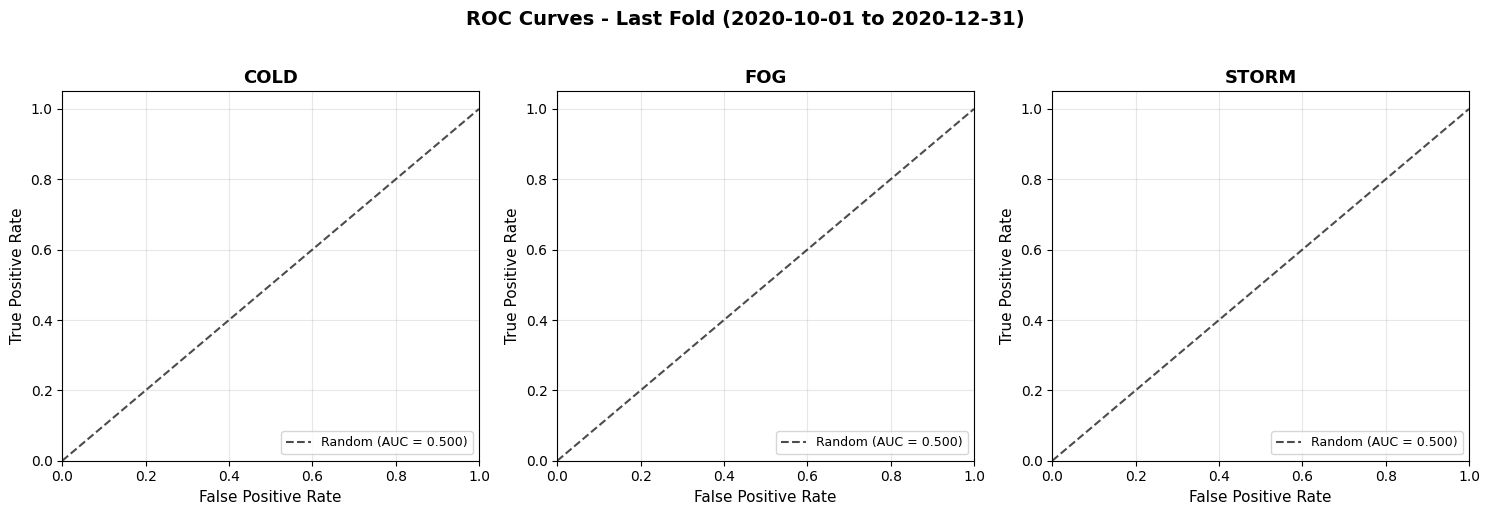


ROC curves saved as 'roc_curves_last_fold.png'


In [ ]:
# Cell moved to Section 9: Visualization (after heatmap)
# See below for ROC curves visualization

In [13]:
# ============================================================
# MAIN TRAINING LOOP - TEMPORAL CROSS-VALIDATION
# ============================================================

# Store results
results = []

# Store predictions for last fold (for ROC curves)
last_fold_predictions = {}  # {target: {model: (y_true, y_pred)}}

# Target columns for specialist models
TARGET_COLS = ['has_cold', 'has_fog', 'has_storm']

# Feature dimension
input_dim = len(ALL_FEATURES)

# Get last fold index
last_fold_num = temporal_cv.get_n_splits()

print("=" * 70)
print("STARTING TEMPORAL CROSS-VALIDATION")
print("=" * 70)
print(f"Features: {input_dim}")
print(f"Targets: {TARGET_COLS}")
print(f"Total samples: {len(df):,}")
print(f"Temporal folds: {temporal_cv.get_n_splits()}")
print("=" * 70)

# Loop through each specialist target
for target_col in TARGET_COLS:
    target_name = target_col.replace('has_', '').upper()
    print(f"\n{'='*70}")
    print(f"TRAINING SPECIALIST MODEL: {target_name}")
    print(f"{'='*70}")
    
    # Initialize storage for this target's last fold predictions
    last_fold_predictions[target_name] = {}
    
    # Temporal cross-validation (expanding window)
    for fold_idx, (train_idx, val_idx) in enumerate(temporal_cv.split(df)):
        # Get the date ranges for this fold
        train_end, val_start, val_end = temporal_cv.folds[fold_idx]
        
        print(f"\n  Fold {fold_idx + 1}/{temporal_cv.get_n_splits()}")
        print(f"    Train: until {train_end}, {len(train_idx):,} samples")
        print(f"    Validate: {val_start} to {val_end}, {len(val_idx):,} samples")
        
        # Extract features and labels
        X_train = df.iloc[train_idx][ALL_FEATURES].values
        y_train = df.iloc[train_idx][target_col].values
        X_val = df.iloc[val_idx][ALL_FEATURES].values
        y_val = df.iloc[val_idx][target_col].values
        
        # Skip if not enough positive samples
        if y_train.sum() < 5 or y_val.sum() < 2:
            print(f"    ⚠ Skipped: insufficient positive samples")
            continue
        
        # Scale features (fit on training data only!)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Get imbalance info for model configuration
        n_positive = int(y_train.sum())
        n_negative = len(y_train) - n_positive
        
        # Create and train models
        models = create_models(n_positive, n_negative)
        
        # Check if this is the last fold
        is_last_fold = (fold_idx + 1) == last_fold_num
        
        for model_name, model in models.items():
            try:
                # All models now use the same interface
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict_proba(X_val_scaled)[:, 1]
                
                # Calculate metrics
                auc = roc_auc_score(y_val, y_pred)
                brier = brier_score_loss(y_val, y_pred)
                
                # Store results
                results.append({
                    'target': target_name,
                    'model': model_name,
                    'fold': fold_idx + 1,
                    'val_period': f"{val_start} to {val_end}",
                    'auc': auc,
                    'brier_score': brier,
                    'n_train': len(y_train),
                    'n_val': len(y_val),
                    'pos_rate_train': y_train.mean(),
                    'pos_rate_val': y_val.mean()
                })
                
                # Store predictions for last fold (for ROC curves)
                if is_last_fold:
                    last_fold_predictions[target_name][model_name] = (y_val, y_pred)
                
            except Exception as e:
                print(f"      ⚠ {model_name}: {str(e)[:40]}")
        
        print(f"    ✓ Complete")

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print(f"Total results: {len(results)}")
print(f"Last fold predictions stored for ROC curves")
print("=" * 70)

STARTING TEMPORAL CROSS-VALIDATION
Features: 36
Targets: ['has_cold', 'has_fog', 'has_storm']
Total samples: 252,616
Temporal folds: 4

TRAINING SPECIALIST MODEL: COLD

  Fold 1/4
    Train: until 2019-12-31, 125,614 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples
    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 157,191 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples
    ✓ Complete

  Fold 3/4
    Train: until 2020-06-30, 188,768 samples
    Validate: 2020-07-01 to 2020-09-30, 31,924 samples
    ✓ Complete

  Fold 4/4
    Train: until 2020-09-30, 220,692 samples
    Validate: 2020-10-01 to 2020-12-31, 31,924 samples
    ✓ Complete

TRAINING SPECIALIST MODEL: FOG

  Fold 1/4
    Train: until 2019-12-31, 125,614 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples
    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 157,191 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples
    ✓ Complete

  Fold 3/4
    Train: until 2020-06-3

## Section 8: Results Aggregation and Analysis

Now we aggregate results across all 4 temporal folds to get robust performance estimates:

- **Mean Score**: Average performance across all validation quarters (Q1-Q4 2020)
- **Standard Deviation**: Variability in performance across different time periods

We report:
- **ROC-AUC**: Ranking ability (higher is better)
- **Brier Score / MSE**: Probability calibration (lower is better)

In [14]:
# ============================================================
# CONVERT RESULTS TO DATAFRAME
# ============================================================

results_df = pd.DataFrame(results)

print("TEMPORAL CROSS-VALIDATION RESULTS")
print(f"  Shape: {results_df.shape}")
print(f"  Evaluates: Model performance on future time periods (temporal generalization)")
print(f"\nResults per target: {results_df.groupby('target').size().to_dict()}")

results_df.head(10)

TEMPORAL CROSS-VALIDATION RESULTS
  Shape: (48, 10)
  Evaluates: Model performance on future time periods (temporal generalization)

Results per target: {'COLD': 16, 'FOG': 16, 'STORM': 16}


,target,model,fold,val_period,auc,brier_score,n_train,n_val,pos_rate_train,pos_rate_val
0,COLD,Logistic_Regression,1,2020-01-01 to 2020-03-31,0.658403,0.280471,125614,31577,0.034033,0.034550
1,COLD,Random_Forest,1,2020-01-01 to 2020-03-31,0.671591,0.137329,125614,31577,0.034033,0.034550
2,COLD,XGBoost,1,2020-01-01 to 2020-03-31,0.669419,0.164149,125614,31577,0.034033,0.034550
3,COLD,CatBoost,1,2020-01-01 to 2020-03-31,0.672972,0.206513,125614,31577,0.034033,0.034550
4,COLD,Logistic_Regression,2,2020-04-01 to 2020-06-30,0.506181,0.180506,157191,31577,0.034137,0.030560
5,COLD,Random_Forest,2,2020-04-01 to 2020-06-30,0.550202,0.127608,157191,31577,0.034137,0.030560
6,COLD,XGBoost,2,2020-04-01 to 2020-06-30,0.546095,0.119078,157191,31577,0.034137,0.030560
7,COLD,CatBoost,2,2020-04-01 to 2020-06-30,0.565272,0.139507,157191,31577,0.034137,0.030560
8,COLD,Logistic_Regression,3,2020-07-01 to 2020-09-30,0.537896,0.175694,188768,31924,0.033539,0.032295
9,COLD,Random_Forest,3,2020-07-01 to 2020-09-30,0.541618,0.164642,188768,31924,0.033539,0.032295


In [15]:
# ============================================================
# AGGREGATE RESULTS BY TARGET AND MODEL
# ============================================================

# Calculate mean and std across all folds
summary_df = results_df.groupby(['target', 'model']).agg({
    'auc': ['mean', 'std'],
    'brier_score': ['mean', 'std']
}).round(4)

# Flatten column names
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

# Display results
print("=" * 80)
print("TEMPORAL CROSS-VALIDATION: MEAN PERFORMANCE ACROSS FOLDS")
print("=" * 80)
print("\nMetrics (evaluated on future time periods):")
print("  - AUC: Higher is better (1.0 = perfect, 0.5 = random)")
print("  - Brier: Lower is better (0.0 = perfect)")
print("=" * 80)

for target in ['COLD', 'FOG', 'STORM']:
    print(f"\n{'-'*60}")
    print(f"TARGET: {target}")
    print(f"{'-'*60}")
    print(f"{'Model':<22} | {'AUC':^20} | {'Brier Score':^16}")
    print("-" * 60)
    
    target_data = summary_df[summary_df['target'] == target].sort_values('auc_mean', ascending=False)
    
    for _, row in target_data.iterrows():
        auc_str = f"{row['auc_mean']:.3f} ± {row['auc_std']:.3f}"
        brier_str = f"{row['brier_score_mean']:.4f} ± {row['brier_score_std']:.4f}"
        print(f"{row['model']:<22} | {auc_str:^20} | {brier_str:^16}")

TEMPORAL CROSS-VALIDATION: MEAN PERFORMANCE ACROSS FOLDS

Metrics (evaluated on future time periods):
  - AUC: Higher is better (1.0 = perfect, 0.5 = random)
  - Brier: Lower is better (0.0 = perfect)

------------------------------------------------------------
TARGET: COLD
------------------------------------------------------------
Model                  |         AUC          |   Brier Score   
------------------------------------------------------------
CatBoost               |    0.589 ± 0.056     | 0.1720 ± 0.0282 
Random_Forest          |    0.580 ± 0.061     | 0.1432 ± 0.0157 
XGBoost                |    0.578 ± 0.062     | 0.1432 ± 0.0186 
Logistic_Regression    |    0.563 ± 0.066     | 0.2147 ± 0.0485 

------------------------------------------------------------
TARGET: FOG
------------------------------------------------------------
Model                  |         AUC          |   Brier Score   
------------------------------------------------------------
XGBoost         

## Section 9: Visualization

Visual comparison of model performance across all targets and metrics.

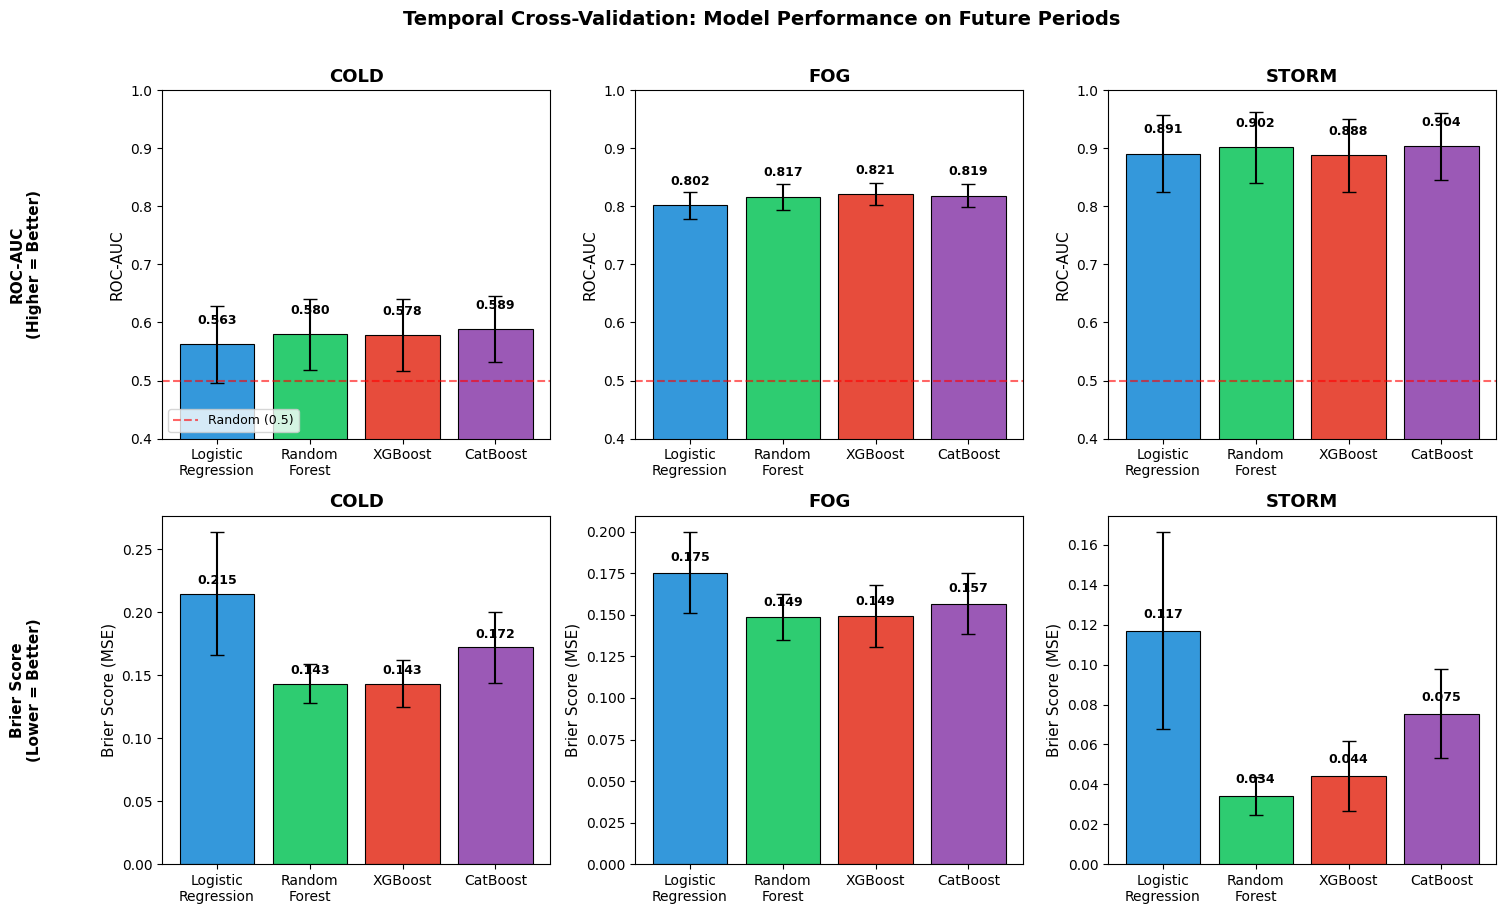


Plot saved as 'temporal_cv_model_comparison.png'


In [16]:
# ============================================================
# VISUALIZATION: MODEL COMPARISON BY TARGET
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

targets = ['COLD', 'FOG', 'STORM']
models = ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'CatBoost']
model_labels = ['Logistic\nRegression', 'Random\nForest', 'XGBoost', 'CatBoost']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for col, target in enumerate(targets):
    target_data = summary_df[summary_df['target'] == target].set_index('model')
    
    # --- ROC-AUC ---
    ax = axes[0, col]
    auc_vals = [target_data.loc[m, 'auc_mean'] if m in target_data.index else 0 for m in models]
    auc_stds = [target_data.loc[m, 'auc_std'] if m in target_data.index else 0 for m in models]
    
    bars = ax.bar(model_labels, auc_vals, yerr=auc_stds, capsize=5, 
                  color=colors, edgecolor='black', linewidth=0.8)
    
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Random (0.5)')
    ax.set_ylabel('ROC-AUC', fontsize=11)
    ax.set_title(f'{target}', fontsize=13, fontweight='bold')
    ax.set_ylim(0.4, 1.0)
    
    # Value labels
    for bar, val in zip(bars, auc_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    if col == 0:
        ax.legend(loc='lower left', fontsize=9)
    
    # --- Brier Score ---
    ax = axes[1, col]
    brier_vals = [target_data.loc[m, 'brier_score_mean'] if m in target_data.index else 0 for m in models]
    brier_stds = [target_data.loc[m, 'brier_score_std'] if m in target_data.index else 0 for m in models]
    
    bars = ax.bar(model_labels, brier_vals, yerr=brier_stds, capsize=5,
                  color=colors, edgecolor='black', linewidth=0.8)
    
    ax.set_ylabel('Brier Score (MSE)', fontsize=11)
    ax.set_title(f'{target}', fontsize=13, fontweight='bold')
    
    # Value labels
    for bar, val in zip(bars, brier_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Row labels
axes[0, 0].annotate('ROC-AUC\n(Higher = Better)', xy=(-0.35, 0.5), xycoords='axes fraction',
                    fontsize=11, fontweight='bold', ha='center', va='center', rotation=90)
axes[1, 0].annotate('Brier Score\n(Lower = Better)', xy=(-0.35, 0.5), xycoords='axes fraction',
                    fontsize=11, fontweight='bold', ha='center', va='center', rotation=90)

plt.suptitle('Temporal Cross-Validation: Model Performance on Future Periods', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('temporal_cv_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'temporal_cv_model_comparison.png'")

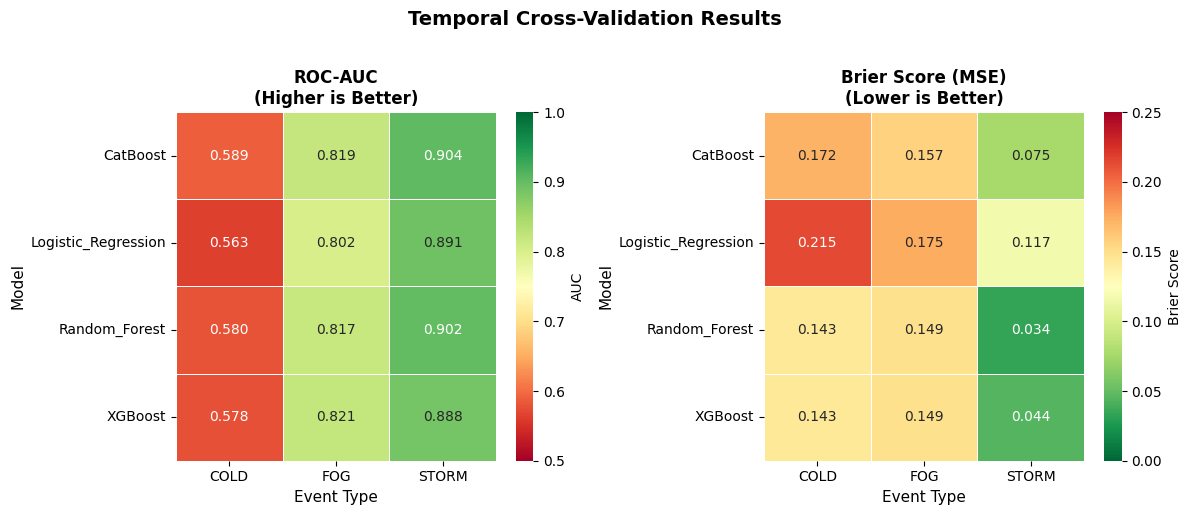


Heatmap saved as 'temporal_cv_heatmap.png'


In [17]:
# ============================================================
# HEATMAP: MODEL PERFORMANCE SUMMARY
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pivot data for heatmaps
auc_pivot = summary_df.pivot(index='model', columns='target', values='auc_mean')
brier_pivot = summary_df.pivot(index='model', columns='target', values='brier_score_mean')

# AUC Heatmap (higher is better)
sns.heatmap(auc_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, ax=axes[0], cbar_kws={'label': 'AUC'},
            linewidths=0.5, linecolor='white')
axes[0].set_title('ROC-AUC\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Event Type', fontsize=11)
axes[0].set_ylabel('Model', fontsize=11)

# Brier Heatmap (lower is better)
sns.heatmap(brier_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            vmin=0, vmax=0.25, ax=axes[1], cbar_kws={'label': 'Brier Score'},
            linewidths=0.5, linecolor='white')
axes[1].set_title('Brier Score (MSE)\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Event Type', fontsize=11)
axes[1].set_ylabel('Model', fontsize=11)

plt.suptitle('Temporal Cross-Validation Results', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('temporal_cv_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved as 'temporal_cv_heatmap.png'")

In [ ]:
# ============================================================
# ROC CURVES FOR LAST FOLD (OPTIONAL VISUALIZATION)
# ============================================================
# Uses predictions stored during training - no re-training needed!

from sklearn.metrics import roc_curve, auc

# Get last fold info for title
last_fold_idx = temporal_cv.get_n_splits() - 1
train_end, val_start, val_end = temporal_cv.folds[last_fold_idx]

print(f"ROC Curves for Last Fold (Fold {last_fold_idx + 1})")
print(f"  Validation Period: {val_start} to {val_end}")
print("  Using stored predictions from training loop")
print("=" * 70)

# Create figure with subplots for each target
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

target_names = ['COLD', 'FOG', 'STORM']
model_names = ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'CatBoost']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for col, target_name in enumerate(target_names):
    ax = axes[col]
    
    # Plot ROC curve for each model using stored predictions
    for model_name, color in zip(model_names, colors):
        try:
            # Get stored predictions from training loop
            y_val, y_pred_proba = last_fold_predictions[target_name][model_name]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Plot
            label = f'{model_name.replace("_", " ")} (AUC = {roc_auc:.3f})'
            ax.plot(fpr, tpr, color=color, linewidth=2, label=label)
            
        except KeyError:
            print(f"  Warning: No predictions stored for {model_name} on {target_name}")
        except Exception as e:
            print(f"  Warning: {model_name} failed for {target_name}: {str(e)[:40]}")
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Random (AUC = 0.500)')
    
    # Styling
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{target_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'ROC Curves - Last Fold ({val_start} to {val_end})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('roc_curves_last_fold.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nROC curves saved as 'roc_curves_last_fold.png'")

## Section 10: Best Model Selection

Identify the best performing model for each event type based on ROC-AUC.

In [18]:
# ============================================================
# BEST MODEL SELECTION
# ============================================================

print("=" * 70)
print("BEST MODEL FOR EACH EVENT TYPE")
print("(Based on Temporal Cross-Validation AUC)")
print("=" * 70)

best_models = {}

for target in ['COLD', 'FOG', 'STORM']:
    target_data = summary_df[summary_df['target'] == target]
    
    if len(target_data) > 0:
        # Best by AUC
        best_auc_idx = target_data['auc_mean'].idxmax()
        best_auc_row = target_data.loc[best_auc_idx]
        
        # Best by Brier (lowest)
        best_brier_idx = target_data['brier_score_mean'].idxmin()
        best_brier_row = target_data.loc[best_brier_idx]
        
        best_models[target] = {
            'model': best_auc_row['model'],
            'auc': best_auc_row['auc_mean'],
            'auc_std': best_auc_row['auc_std'],
            'brier': best_auc_row['brier_score_mean']
        }
        
        print(f"\n{target}:")
        print(f"  Best by AUC:   {best_auc_row['model']} (AUC: {best_auc_row['auc_mean']:.3f} ± {best_auc_row['auc_std']:.3f})")
        print(f"  Best by Brier: {best_brier_row['model']} (Brier: {best_brier_row['brier_score_mean']:.4f})")

print("\n" + "=" * 70)
print("FINAL RECOMMENDATION")
print("=" * 70)
print("\nFor deployment to future time periods, use:")
print(f"{'Target':<10} {'Model':<22} {'AUC':>12} {'Brier':>12}")
print("-" * 56)
for target, info in best_models.items():
    print(f"{target:<10} {info['model']:<22} {info['auc']:.3f}±{info['auc_std']:.3f}  {info['brier']:.4f}")
print("=" * 70)

BEST MODEL FOR EACH EVENT TYPE
(Based on Temporal Cross-Validation AUC)

COLD:
  Best by AUC:   CatBoost (AUC: 0.589 ± 0.056)
  Best by Brier: Random_Forest (Brier: 0.1432)

FOG:
  Best by AUC:   XGBoost (AUC: 0.821 ± 0.019)
  Best by Brier: Random_Forest (Brier: 0.1488)

STORM:
  Best by AUC:   CatBoost (AUC: 0.904 ± 0.058)
  Best by Brier: Random_Forest (Brier: 0.0341)

FINAL RECOMMENDATION

For deployment to future time periods, use:
Target     Model                           AUC        Brier
--------------------------------------------------------
COLD       CatBoost               0.589±0.056  0.1720
FOG        XGBoost                0.821±0.019  0.1493
STORM      CatBoost               0.904±0.058  0.0755
